## Imports

In [1]:
from time import sleep

In [2]:
import numpy as np

In [3]:
import scipy as sp
from scipy import ndimage

In [4]:
from PIL import Image, ImageDraw

In [5]:
import PIL

In [6]:
PIL.__version__

'8.3.2'

In [7]:
from picamera import PiCamera

# Lab 8
## PyVision

The purpose of this lab is to help you become more familiar with "exploratory computing," Python, Jupyter notebooks, and even a bit of Linux.  That is a lot to bight off in 1.5 hours, so let's get started!

What to do:

Execute each of the cells in order.  Do not skip any cells.  This lab is written such that things should work out if you start at the top and work your way down.

Along the way, you will find cells which must be corrected in order to get everything to work properly.  These will be indicated with <font color='red' size='5'>Bold Red Text</font>

## Image Processing

Computer images can come in a variety of formats, but the most common is that of a dense RGB Array.  For an image which is $n+1$ pixels wide and $m+1$ pixels tall, this would look something like:
```
[[[r00, g00, b00], [r01, g01, b01], ... , [r0n, g0n, b0n]],
 [[r10, g10, b10], [r11, g11, b11], ... , [r1n, g1n, b1n]],
 ...
 [[rm0, gm0, bm0], [rm1, gm1, bm1], ... , [rmn, gmn, bmn]]]
 ```
 

Note that the $(0, 0)$ pixels is in the upper-left hand corner.  The pixels fill in the same way you would write words on the page.  Similar to matrices, we describe the size of such a matrix by starting at the outside and working our way in.  The size of the above array would be `(m,n,3)`.  In other words, it is `m` pixels tall, `n` pixels wide, and has `3` color components.

Additionally, most computer monitors operate in 8-bit scale, meaning that the red value of a pixel can have values in the range [0, ..., 255].  Why 255?  Because $2^8 - 1 = 255$.

Let us begin by creating an array of zeros representing an image which is {H,W} = {150, 200}.

In [8]:
testImageData = np.zeros(shape=(150, 200, 3), dtype=np.uint8)

We can visualize this data by converting it into an Image object.

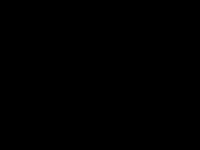

In [9]:
Image.fromarray(testImageData)

We can use our Numpy indexing skills to alter this image.  For instance, let's put a red box in the middle.

In [10]:
testImageData[75-20:75+20, 100-20:100+20] = [255, 0, 0]

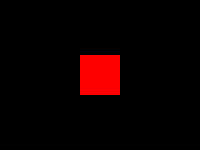

In [11]:
Image.fromarray(testImageData)

Ok... your turn!  

<font color='red' size='5'>Alter the cell below to:</font> 
* Put a blue box in the upper-left hand corner
* Put a green box in the lower-right hand corner
* Put a white box in the upper-right hand corner
* Put a red disk near {x:110, y:85}


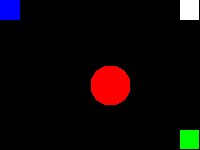

In [12]:
testImageData[:, :] = [0, 0, 0]                    # Make the image black
testImageData[0:20, 0:20] = [0, 0, 255]            # 
testImageData[130:150-1, 180:200-1] = [0, 255, 0]
testImageData[0:20, 180:200-1] = [255, 255, 255]
for x in range(200):
    for y in range(150):
        if (x-110)**2 + (y-85)**2 < 20**2:
            testImageData[y, x] = [255, 0, 0]
Image.fromarray(testImageData)

Let's see if we can look for only the red objects in the image.  We're going to do this by dividing the image up into three color channels (red, green, blue) and then calculating a color distance for each pixel.  We'll borrow the typical distance formula from geometry $d = \sqrt{((x_e - x_s)^2 + (y_e - y_s)^2 + (z_e - z_s)^2}$, but in this case, we'll use the colors as coordinates.

In [13]:
def computeColorDistance(imageData, rgbTargetColor):
    rVal, gVal, bVal = rgbTargetColor       # break the target color up into it's red, green, and blue values
    rCh = imageData[:,:,0].astype('float')  # separate the red channel from the image. (m,n) of 'float'.
    gCh = imageData[:,:,1].astype('float')  #              green
    bCh = imageData[:,:,2].astype('float')  #              blue
    rDist = (rCh - rVal)/255.               # compute the "red distance" and normalize to one.  (m,n) of 'float' in range [0, 1]
    gDist = (gCh - gVal)/255.               #             "green distance" 
    bDist = (bCh - bVal)/255.               #             "blue distance"
                                            # Compute the normalized distance.  (m, n) 'float' in range [0, 1]
    colorDist = ((rDist**2 + gDist**2 + bDist**2)**0.5) / ((3)**0.5)
    return colorDist

Code will often incorporate the idea of Unit Testing.  The idea is that you test the code a small piece of the code (i.e. a "unit") for a handful of inputs/outputs that you can calculate and understand "by hand."  If all of the "units" behave as expected, then the code should work as a whole.

Let's check our color distance finder for several single pixel images.

In [14]:
# Black Pixel to White color -> 1.0
testImageDataUT = np.array([[[0, 0, 0]]], 'uint8')
dUT = computeColorDistance(testImageDataUT, [255, 255, 255])
print("expected:", [[1.]], "  got:", dUT)

# White to White -> 0.0
testImageDataUT = np.array([[[255, 255, 255]]], 'uint8')
dUT = computeColorDistance(testImageDataUT, [255, 255, 255])
print("expected:", [[0.]], "  got:", dUT)

# Red to Red -> 0.0
testImageDataUT = np.array([[[255, 0, 0]]], 'uint8')
dUT = computeColorDistance(testImageDataUT, [255, 0, 0])
print("expected:", [[0.]], "  got:", dUT)

# Red to Black -> 1/sqrt(3) = 0.577
testImageDataUT = np.array([[[255, 0, 0]]], 'uint8')
dUT = computeColorDistance(testImageDataUT, [0, 0, 0])
print("expected:", [[0.577]], "  got:", dUT)

expected: [[1.0]]   got: [[1.]]
expected: [[0.0]]   got: [[0.]]
expected: [[0.0]]   got: [[0.]]
expected: [[0.577]]   got: [[0.57735027]]


In [15]:
computeColorDistance(testImageData, [255, 0, 0])

array([[0.81649658, 0.81649658, 0.81649658, ..., 0.81649658, 0.81649658,
        0.57735027],
       [0.81649658, 0.81649658, 0.81649658, ..., 0.81649658, 0.81649658,
        0.57735027],
       [0.81649658, 0.81649658, 0.81649658, ..., 0.81649658, 0.81649658,
        0.57735027],
       ...,
       [0.57735027, 0.57735027, 0.57735027, ..., 0.81649658, 0.81649658,
        0.57735027],
       [0.57735027, 0.57735027, 0.57735027, ..., 0.81649658, 0.81649658,
        0.57735027],
       [0.57735027, 0.57735027, 0.57735027, ..., 0.57735027, 0.57735027,
        0.57735027]])

In [16]:
def floatLumTo8BitRGB(lumFloat):
    lum8Bit = np.clip(256*lumFloat, 0, 255).astype('uint8')  # Rescale the image data to 'uint8' in range [0, 255]
    lum8BitRGB = np.dstack((lum8Bit, lum8Bit, lum8Bit))      # Turn it into RGB image.  The function np.dstack combines three 2D mxn arrays into one mxnx3 array.
    return lum8BitRGB

In [17]:
def thresholdBinarize(distData, threshold):
    maskData = np.where(distData < threshold, 1, 0)
    return maskData

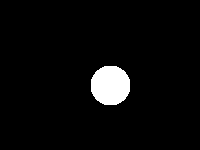

In [18]:
distData = computeColorDistance(testImageData, [255, 0, 0])
isRedEnough = thresholdBinarize(distData, 0.1)
Image.fromarray(floatLumTo8BitRGB(isRedEnough))

In [19]:
ndimage.measurements.center_of_mass(isRedEnough)

(85.0, 110.0)

In [20]:
def imageDimmer(imageData, mask, dimFactor):
    scalingImageData = (mask.astype('float') + dimFactor)/(1 + dimFactor)  # FIX ME
    dimmedImageData = (imageData*np.atleast_3d(scalingImageData)).astype('uint8')
    return dimmedImageData

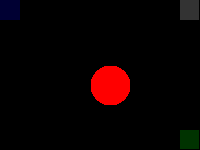

In [21]:
dimmedImageData = imageDimmer(testImageData, isRedEnough, 0.25)
Image.fromarray(dimmedImageData)

We can change various properties of the camera such as the resolution and frame rate.

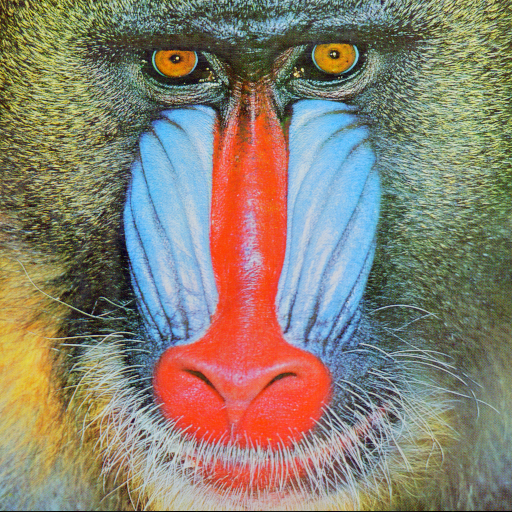

In [22]:
im = Image.open('baboon.png')
im

In [23]:
baboonImageData = np.array(Image.open('baboon.png'))

317.2595785440613 245.16890166028097


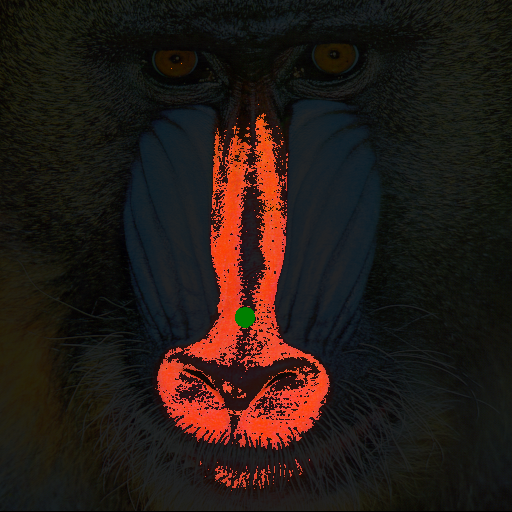

In [24]:
distData = computeColorDistance(baboonImageData, [255, 20, 20])
isRedEnough = thresholdBinarize(distData, 0.2)
dimmedImageData = imageDimmer(baboonImageData, isRedEnough, 0.2)
(noseY, noseX) = ndimage.measurements.center_of_mass(isRedEnough)
print(noseY, noseX)
im = Image.fromarray(dimmedImageData)
draw = ImageDraw.Draw(im)
draw.regular_polygon((noseX, noseY, 10), n_sides=16, fill='green')
im


# Image Capture

We need a place to put the data.  A Numpy array is particularly well suited for this because it is a dense array.  If it is the proper shape andhe data can be directly transThe numpy array must match the size of the incoming array exactly, or else weird things happen.  Note that this is a color camera, so each pixel has an RGB (Red, Green, Blue) value.

In [25]:
from picamera import PiCamera
import numpy as np
from PIL import Image, ImageDraw

In [26]:
imageData = np.zeros(shape=(240, 320, 3), dtype=np.uint8)

In [27]:
try:
    cam = PiCamera()
except:
    pass

In [28]:
cam.resolution = (320, 240)
cam.framerate = 10
cam.rotation = 180

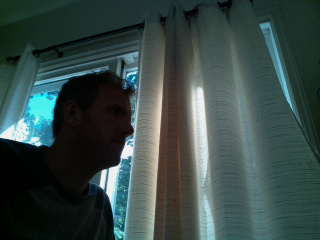

In [29]:
cam.capture(imageData, 'rgb')
Image.fromarray(imageData)

# Moving the Servos

In [30]:
from adafruit_servokit import ServoKit

In [31]:
servoBoard = ServoKit(channels=16)

On my setup, the tiltServo and panServo actuates from 0-180

In [32]:
tiltServo = servoBoard.servo[0]
panServo = servoBoard.servo[1]

In [33]:
tiltServo.angle = 90.1
panServo.angle = 90.

# Putting it all together

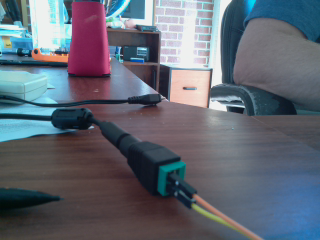

In [37]:
cam.capture(imageData, 'rgb')
Image.fromarray(imageData)

In [35]:
centY = 120
centX = 160

105.40043763676148 160.76258205689277


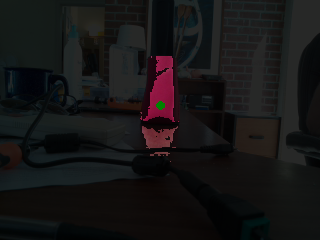

In [44]:
targetColor = [120, 32, 77]
cam.capture(imageData, 'rgb')
distData = computeColorDistance(imageData, targetColor)
isRedEnough = thresholdBinarize(distData, 0.08)
dimmedImageData = imageDimmer(imageData, isRedEnough, 0.2)
(foundY, foundX) = ndimage.measurements.center_of_mass(isRedEnough)
print(foundY, foundX)
im = Image.fromarray(dimmedImageData)
draw = ImageDraw.Draw(im)
draw.regular_polygon((foundX, foundY, 4), n_sides=16, fill='green')
errorX = foundX - centX
errorY = foundY - centY
tiltServo.angle = tiltServo.angle - 0.1*errorY
panServo.angle = panServo.angle + 0.1*errorX
im

In [108]:
errorX = foundX - centX
errorY = foundY - centY

In [49]:
from IPython.display import clear_output, display

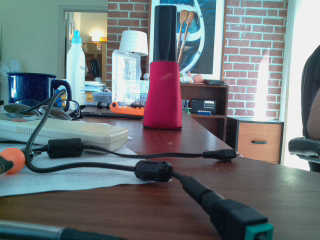

In [52]:
for i in range(10):
    cam.capture(imageData, 'rgb')
    im = Image.fromarray(imageData)
    clear_output()
    display(im)
    sleep(0.4)

In [ ]:
targetColor = [120, 32, 77]
cam.capture(imageData, 'rgb')
distData = computeColorDistance(imageData, targetColor)
isRedEnough = thresholdBinarize(distData, 0.08)
dimmedImageData = imageDimmer(imageData, isRedEnough, 0.2)
(foundY, foundX) = ndimage.measurements.center_of_mass(isRedEnough)
print(foundY, foundX)
im = Image.fromarray(dimmedImageData)
draw = ImageDraw.Draw(im)
draw.regular_polygon((foundX, foundY, 4), n_sides=16, fill='green')
errorX = foundX - centX
errorY = foundY - centY
tiltServo.angle = tiltServo.angle - 0.1*errorY
panServo.angle = panServo.angle + 0.1*errorX
im

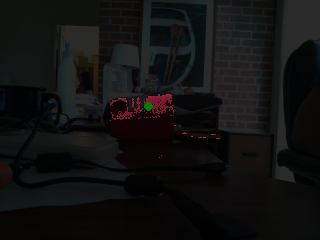

KeyboardInterrupt: 

In [54]:
targetColor = [120, 32, 77]
maxColorDist = 0.08
while True:
    cam.capture(imageData, 'rgb')
    distData = computeColorDistance(imageData, targetColor)
    isRedEnough = thresholdBinarize(distData, maxColorDist)
    dimmedImageData = imageDimmer(imageData, isRedEnough, 0.2)
    (foundY, foundX) = ndimage.measurements.center_of_mass(isRedEnough)
    im = Image.fromarray(dimmedImageData)
    draw = ImageDraw.Draw(im)
    draw.regular_polygon((foundX, foundY, 4), n_sides=16, fill='green')
    errorX = foundX - centX
    errorY = foundY - centY
    tiltServo.angle = tiltServo.angle - 0.1*errorY
    panServo.angle = panServo.angle + 0.1*errorX
    clear_output()
    display(im)
    sleep(0.5)